In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp

# # Define la ruta a la carpeta en tu Drive donde están tus módulos
# # Asegúrate de CAMBIAR 'mis_modulos' por el nombre real de tu carpeta
# module_path1 = '/kaggle/input/mi-mlp/other/default/3'
# module_path2 = '/kaggle/input/emnist-bymerge'



# sys.path.append(module_path1)
# sys.path.append(module_path2)

from metrics import *
from models import *


In [ ]:
# Cargar los archivos .npy
X_images = np.load('X_images.npy')
y_images = np.load('y_images.npy')

print(f"X_images shape: {X_images.shape}")
print(f"y_images shape: {y_images.shape}")

X_images shape: (809555, 28, 28)
y_images shape: (809555,)


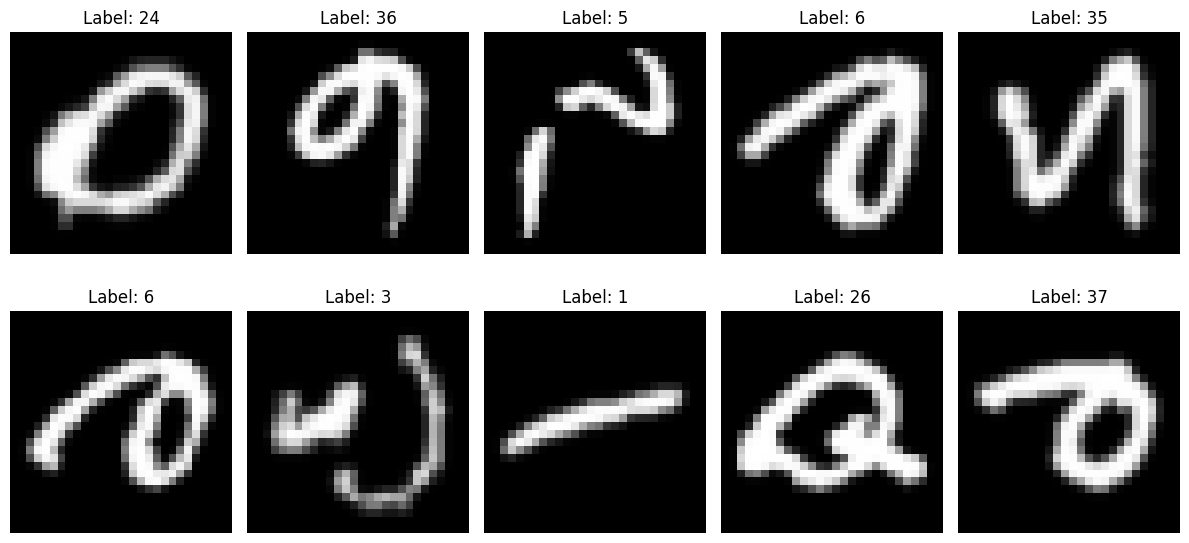

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(X_images[i], cmap='gray')
    axes[i].set_title(f'Label: {y_images[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Valores únicos: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Cantidad de clases: 47

Primeros 20 valores: [24 36  5  6 35  6  3  1 26 37 39  5  3  7 38 14 28  6 36 46]

=== Distribución de clases ===
Clase 0: 40263 imágenes (4.97%)
Clase 1: 44604 imágenes (5.51%)
Clase 2: 39972 imágenes (4.94%)
Clase 3: 41012 imágenes (5.07%)
Clase 4: 39054 imágenes (4.82%)
Clase 5: 36506 imágenes (4.51%)
Clase 6: 39837 imágenes (4.92%)
Clase 7: 41793 imágenes (5.16%)
Clase 8: 39479 imágenes (4.88%)
Clase 9: 39433 imágenes (4.87%)
Clase 10: 7369 imágenes (0.91%)
Clase 11: 4426 imágenes (0.55%)
Clase 12: 15019 imágenes (1.86%)
Clase 13: 5241 imágenes (0.65%)
Clase 14: 5685 imágenes (0.70%)
Clase 15: 10522 imágenes (1.30%)
Clase 16: 2864 imágenes (0.35%)
Clase 17: 3573 imágenes (0.44%)
Clase 18: 17046 imágenes (2.11%)
Clase 19: 6501 imágenes (0.80%)
Clase 20: 5707 imágenes (0.70%)
Clase 21: 23639 imágenes (

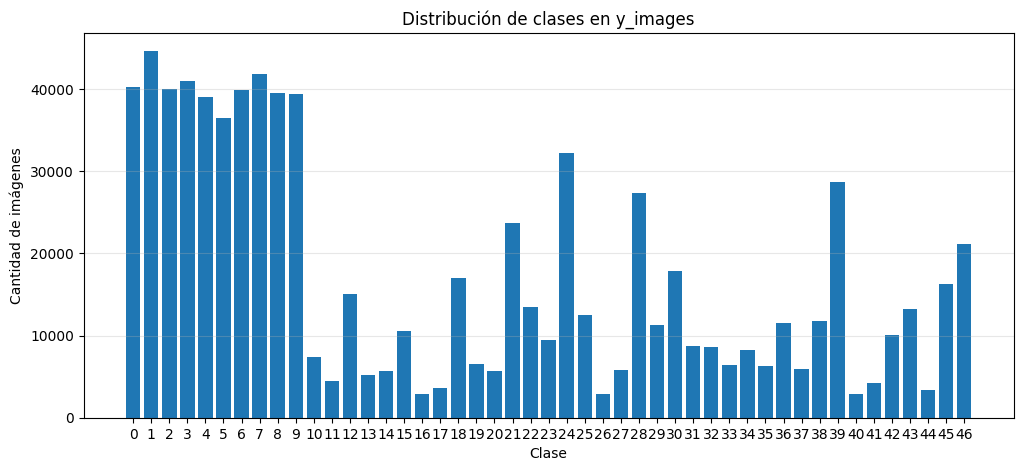

In [4]:

print(f"Valores únicos: {np.unique(y_images)}")
print(f"Cantidad de clases: {len(np.unique(y_images))}")
print(f"\nPrimeros 20 valores: {y_images[:20]}")

unique, counts = np.unique(y_images, return_counts=True)
print("\n=== Distribución de clases ===")
for label, count in zip(unique, counts):
    print(f"Clase {label}: {count} imágenes ({count/len(y_images)*100:.2f}%)")

# Visualizar la distribución
plt.figure(figsize=(12, 5))
plt.bar(unique, counts)
plt.xlabel('Clase')
plt.ylabel('Cantidad de imágenes')
plt.title('Distribución de clases en y_images')
plt.xticks(unique)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 1. Análisis y Preprocesamiento de Datos

## 1.a) Visualización de imágenes del dataset

=== Visualización de 3 imágenes del dataset ===

Imagen 0: Shape (28, 28), Min=0, Max=255, Clase=24
Imagen 1: Shape (28, 28), Min=0, Max=255, Clase=36
Imagen 2: Shape (28, 28), Min=0, Max=255, Clase=5


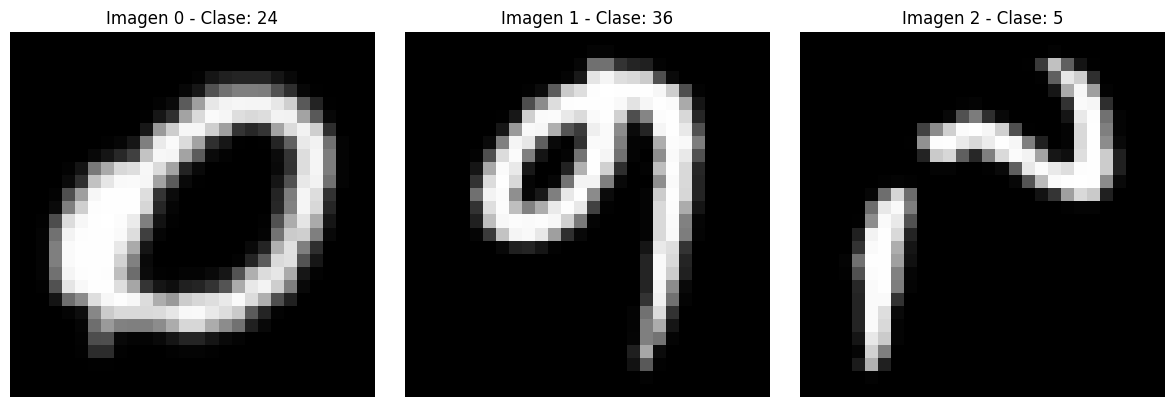

In [5]:
# Visualizar al menos 3 imágenes como pide el ejercicio
print("=== Visualización de 3 imágenes del dataset ===\n")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    img = X_images[i].reshape(28, 28)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Imagen {i} - Clase: {y_images[i]}')
    axes[i].axis('off')
    print(f"Imagen {i}: Shape {img.shape}, Min={img.min()}, Max={img.max()}, Clase={y_images[i]}")

plt.tight_layout()
plt.show()

## 1.b) División del dataset en Train, Validation y Test

In [6]:
# División del dataset
# Proporciones: 70% Train, 15% Validation, 15% Test

np.random.seed(42)  # Para reproducibilidad

# Obtener índices aleatorios
n_samples = X_images.shape[0]
indices = np.random.permutation(n_samples)

# Calcular tamaños
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)
test_size = n_samples - train_size - val_size

# Dividir índices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Crear subconjuntos
X_train = X_images[train_indices]
y_train = y_images[train_indices]

X_val = X_images[val_indices]
y_val = y_images[val_indices]

X_test = X_images[test_indices]
y_test = y_images[test_indices]

print("=== División del dataset ===")
print(f"Train: {X_train.shape[0]} muestras ({X_train.shape[0]/n_samples*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} muestras ({X_val.shape[0]/n_samples*100:.1f}%)")
print(f"Test: {X_test.shape[0]} muestras ({X_test.shape[0]/n_samples*100:.1f}%)")
print(f"Total: {n_samples} muestras")

=== División del dataset ===
Train: 566688 muestras (70.0%)
Validation: 121433 muestras (15.0%)
Test: 121434 muestras (15.0%)
Total: 809555 muestras


## 1.c) Normalización de los datos

In [7]:
# Normalizar dividiendo por 255 para que el máximo sea 1
print("=== Antes de la normalización ===")
print(f"X_train - Min: {X_train.min()}, Max: {X_train.max()}")
print(f"X_val - Min: {X_val.min()}, Max: {X_val.max()}")
print(f"X_test - Min: {X_test.min()}, Max: {X_test.max()}")

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("\n=== Después de la normalización ===")
print(f"X_train - Min: {X_train.min():.4f}, Max: {X_train.max():.4f}")
print(f"X_val - Min: {X_val.min():.4f}, Max: {X_val.max():.4f}")
print(f"X_test - Min: {X_test.min():.4f}, Max: {X_test.max():.4f}")

# Reshape para que sean vectores (flatten) - necesario para MLP
# De (n_samples, 28, 28) a (n_samples, 784)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("\n=== Después del reshape para MLP ===")
print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_val_flat shape: {X_val_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

# Transponer para que tenga formato (features, samples) como espera nuestro MLP
X_train_T = X_train_flat.T
X_val_T = X_val_flat.T
X_test_T = X_test_flat.T

print("\n=== Transposición para formato (features, samples) ===")
print(f"X_train_T shape: {X_train_T.shape} - (features={X_train_T.shape[0]}, samples={X_train_T.shape[1]})")
print(f"X_val_T shape: {X_val_T.shape}")
print(f"X_test_T shape: {X_test_T.shape}")

=== Antes de la normalización ===
X_train - Min: 0, Max: 255
X_val - Min: 0, Max: 255
X_test - Min: 0, Max: 255

=== Después de la normalización ===
X_train - Min: 0.0000, Max: 1.0000
X_val - Min: 0.0000, Max: 1.0000
X_test - Min: 0.0000, Max: 1.0000

=== Después del reshape para MLP ===
X_train_flat shape: (566688, 784)
X_val_flat shape: (121433, 784)
X_test_flat shape: (121434, 784)

=== Transposición para formato (features, samples) ===
X_train_T shape: (784, 566688) - (features=784, samples=566688)
X_val_T shape: (784, 121433)
X_test_T shape: (784, 121434)


In [8]:
# Convertir labels a one-hot encoding para cross-entropy
def to_one_hot(y, n_classes):
    """Convierte labels a formato one-hot encoding"""
    one_hot = np.zeros((n_classes, y.shape[0]))
    one_hot[y, np.arange(y.shape[0])] = 1
    return one_hot

n_classes = len(np.unique(y_images))
print(f"Número de clases: {n_classes}")

y_train_onehot = to_one_hot(y_train, n_classes)
y_val_onehot = to_one_hot(y_val, n_classes)
y_test_onehot = to_one_hot(y_test, n_classes)

print(f"\ny_train_onehot shape: {y_train_onehot.shape} - (classes={y_train_onehot.shape[0]}, samples={y_train_onehot.shape[1]})")
print(f"y_val_onehot shape: {y_val_onehot.shape}")
print(f"y_test_onehot shape: {y_test_onehot.shape}")

# Verificar que la codificación one-hot está correcta
print("\n=== Verificación de one-hot encoding ===")
print(f"Ejemplo - y_train[0] = {y_train[0]}")
print(f"One-hot correspondiente (primeras 10 posiciones): {y_train_onehot[:10, 0]}")

Número de clases: 47

y_train_onehot shape: (47, 566688) - (classes=47, samples=566688)
y_val_onehot shape: (47, 121433)
y_test_onehot shape: (47, 121434)

=== Verificación de one-hot encoding ===
Ejemplo - y_train[0] = 4
One-hot correspondiente (primeras 10 posiciones): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


# 2. Entrenamiento del Modelo MLP con Batch Training

In [9]:
input_size = 784 
n_classes = 47  

L = 2                  
M = [128, 64]          
batch_size = 256     
learning_rate = 0.01   
epochs = 30            
init_method = 'glorot' 

layer_sizes = [input_size] + M + [n_classes]

mlp = MLP(n_layers=L+1, layer_sizes=layer_sizes, batch_size=batch_size, init=init_method)

## 2.c) Entrenamiento del Modelo M0

In [10]:
print("--- Convirtiendo datos a float32 ---")
X_train_T = X_train_T.astype(np.float32)
y_train_onehot = y_train_onehot.astype(np.float32)
X_val_T = X_val_T.astype(np.float32)
y_val_onehot = y_val_onehot.astype(np.float32)
X_test_T = X_test_T.astype(np.float32) # También para el futuro
y_test_onehot = y_test_onehot.astype(np.float32) # También para el futuro

# Verificar (opcional)
print(f"X_train_T dtype: {X_train_T.dtype}")
print(f"y_train_onehot dtype: {y_train_onehot.dtype}")

--- Convirtiendo datos a float32 ---
X_train_T dtype: float32
y_train_onehot dtype: float32


In [11]:
print("=== Iniciando entrenamiento del modelo M0 ===\n")
print(f"Arquitectura: {layer_sizes}")
print(f"Datos de entrenamiento: {X_train_T.shape[1]} muestras")
print(f"Datos de validación: {X_val_T.shape[1]} muestras")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Épocas: {epochs}\n")

import time
start_time = time.time()

history_M0 = mlp.train(
    X_train_T,  
    y_train_onehot,  
    X_val=X_val_T, 
    y_val=y_val_onehot,
    epochs=epochs, 
    learning_rate=learning_rate,
    verbose=True
)

end_time = time.time()
training_time = end_time - start_time

print(f"\n=== Entrenamiento completado ===")
print(f"Tiempo total: {training_time:.2f} segundos ({training_time/60:.2f} minutos)")
print(f"Tiempo por época: {training_time/epochs:.2f} segundos")

import cupy as cp
train_losses = [float(cp.asnumpy(loss)) if isinstance(loss, cp.ndarray) else float(loss) 
                for loss in history_M0['train_loss']]
val_losses = [float(cp.asnumpy(loss)) if isinstance(loss, cp.ndarray) else float(loss) 
              for loss in history_M0['val_loss']]

print(f"\nLoss final - Train: {train_losses[-1]:.4f}, Validation: {val_losses[-1]:.4f}")

=== Iniciando entrenamiento del modelo M0 ===

Arquitectura: [784, 128, 64, 47]
Datos de entrenamiento: 566688 muestras
Datos de validación: 121433 muestras
Batch size: 256
Learning rate: 0.01
Épocas: 30

Epoch 0/30 - LR: 0.010000 - Train Loss: 1.9453 - Val Loss: 1.2526
Epoch 10/30 - LR: 0.010000 - Train Loss: 0.5940 - Val Loss: 0.5741
Epoch 20/30 - LR: 0.010000 - Train Loss: 0.4830 - Val Loss: 0.4777

Training completed. Best validation loss: 0.4396

TRAINING TIME SUMMARY
Total time: 162.13s (2.70 min)
Epochs trained: 30
Time per epoch: 5.40s


=== Entrenamiento completado ===
Tiempo total: 162.13 segundos (2.70 minutos)
Tiempo por época: 5.40 segundos

Loss final - Train: 0.4409, Validation: 0.4396


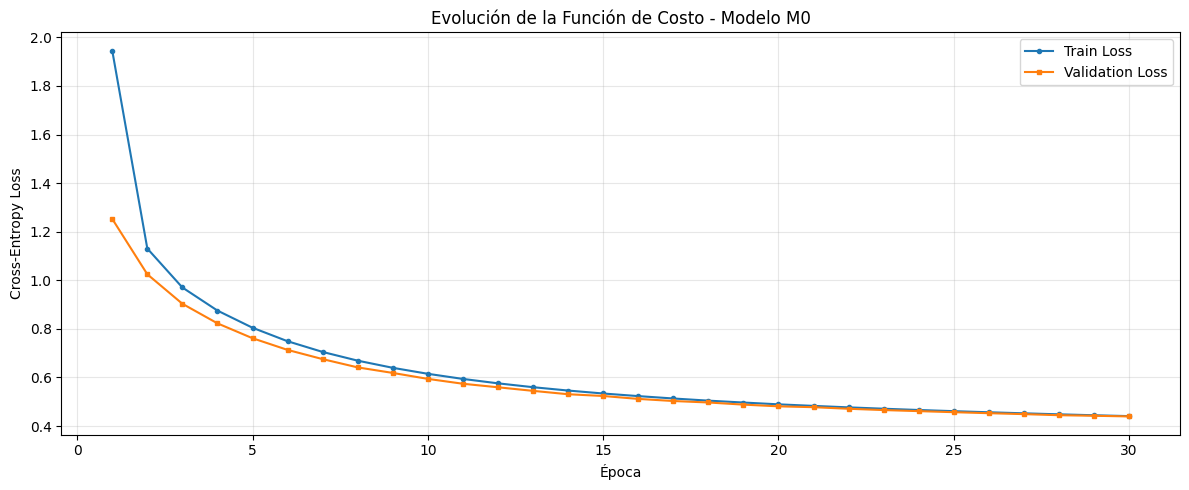

=== Análisis de Convergencia ===
Mejor loss de validación: 0.4396 en época 30
Diferencia train-val al final: 0.0013
✓ No hay evidencia de overfitting


In [12]:
# Graficar la evolución de la función de costo
plt.figure(figsize=(12, 5))

plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o', markersize=3)
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s', markersize=3)
plt.xlabel('Época')
plt.ylabel('Cross-Entropy Loss')
plt.title('Evolución de la Función de Costo - Modelo M0')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Análisis de convergencia
print("=== Análisis de Convergencia ===")
print(f"Mejor loss de validación: {min(val_losses):.4f} en época {val_losses.index(min(val_losses))+1}")
print(f"Diferencia train-val al final: {abs(train_losses[-1] - val_losses[-1]):.4f}")

# Detectar posible overfitting
if train_losses[-1] < val_losses[-1]:
    gap = val_losses[-1] - train_losses[-1]
    if gap > 0.1:
        print(f"⚠️ Posible overfitting detectado (gap: {gap:.4f})")
    else:
        print(f"✓ Gap train-val aceptable ({gap:.4f})")
else:
    print("✓ No hay evidencia de overfitting")


Cross-Entropy Final (Train): 0.4409
Cross-Entropy Final (Validation): 0.4396

=== Métricas en Entrenamiento (TRAIN) para M0 ===
metricas
Accuracy: 0.8573 (85.73%)
F1-Score Macro: 0.8098
Precision promedio: 0.8356
Recall promedio: 0.7998

=== Métricas en Validación (VAL) para M0 ===
metricas
Accuracy: 0.8555 (85.55%)
F1-Score Macro: 0.8059
Precision promedio: 0.8303
Recall promedio: 0.7953


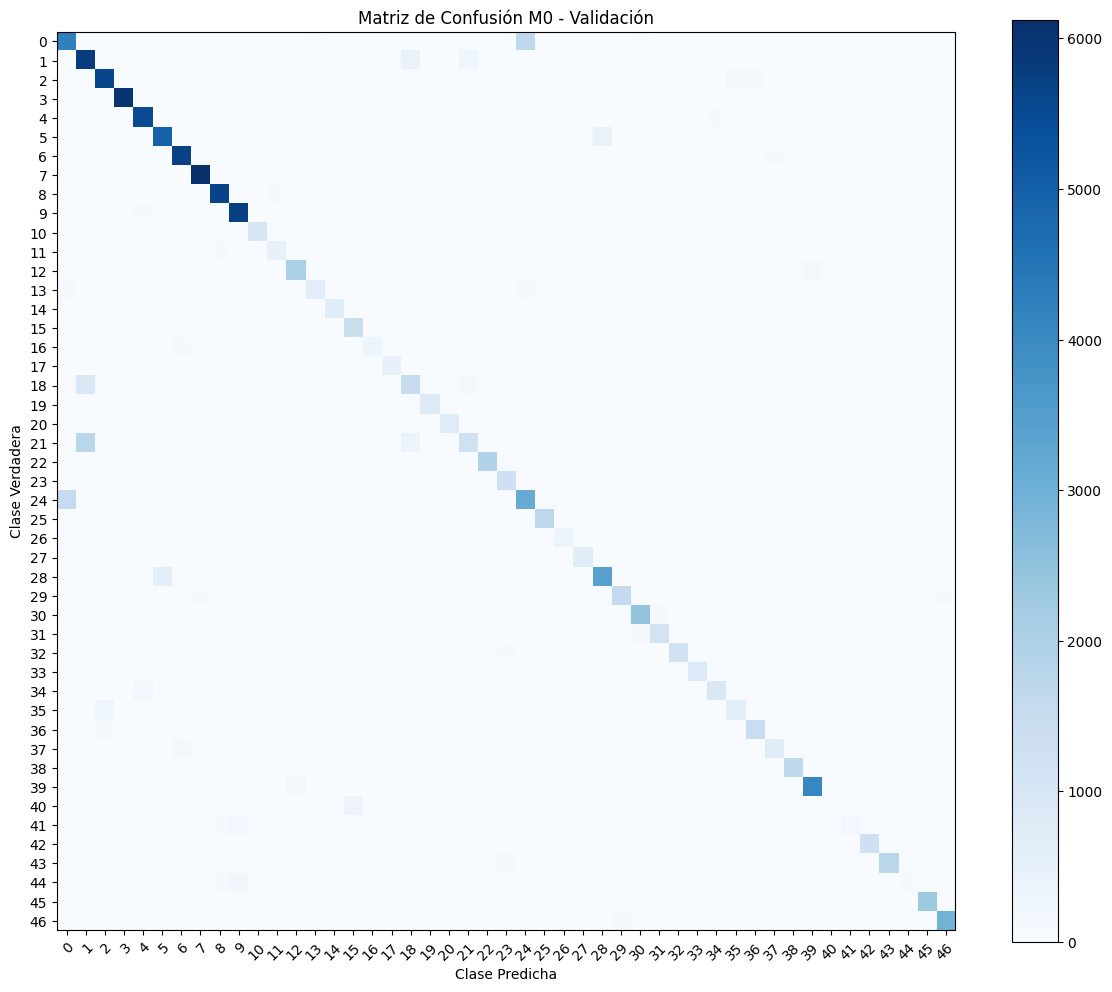

In [13]:



y_pred_train_M0 = mlp.predict(cp.asarray(X_train_T))
y_pred_train_cpu = cp.asnumpy(y_pred_train_M0)

y_pred_val_M0 = mlp.predict(cp.asarray(X_val_T))
y_pred_val_cpu = cp.asnumpy(y_pred_val_M0)

# --- Métricas y Reporte ---

# Reportar Loss (el valor final se toma del entrenamiento en la celda 12)
# Reemplazar con los valores reales si ya ejecutaste la celda 12 y tienes el output
train_loss_final = history_M0['train_loss'][-1]
val_loss_final = history_M0['val_loss'][-1]

print(f"\nCross-Entropy Final (Train): {train_loss_final:.4f}")
print(f"Cross-Entropy Final (Validation): {val_loss_final:.4f}")

print("\n=== Métricas en Entrenamiento (TRAIN) para M0 ===")
metrics_M0_train = evaluate_model(y_train, y_pred_train_cpu, n_classes=n_classes, verbose=True)

print("\n=== Métricas en Validación (VAL) para M0 ===")
metrics_M0_val = evaluate_model(y_val, y_pred_val_cpu, n_classes=n_classes, verbose=True)

plot_confusion_matrix(metrics_M0_val['confusion_matrix'], title='Matriz de Confusión M0 - Validación')
plt.show()



# 3. Modelos Avanzados - Optimizaciones

FALTA REPORTAR TIEMPO DE ENTRENAMIENTO

HAY INCONCISTENCIAS EN LOS HIPERPARAMETROS DE CADA MODELO


In [14]:

# ----------------------------------------------------------------------------
# 2. Learning Rate Scheduling Lineal
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("2. LEARNING RATE SCHEDULING LINEAL")
print("="*80)
print("Decay lineal: LR va de 0.01 a 0.001 en 100 épocas (entrenamos 50)\n")
model_linear = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
                   batch_size=batch_size, optimizer='sgd')
history_linear = model_linear.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                    epochs=50, learning_rate=0.01,
                                    lr_schedule='linear',
                                    lr_schedule_params={'final_lr': 0.001, 'total_epochs': 100},
                                    verbose=True)



2. LEARNING RATE SCHEDULING LINEAL
Decay lineal: LR va de 0.01 a 0.001 en 100 épocas (entrenamos 50)

Epoch 0/50 - LR: 0.010000 - Train Loss: 3.7285 - Val Loss: 3.5533
Epoch 10/50 - LR: 0.009100 - Train Loss: 0.9293 - Val Loss: 0.8845
Epoch 20/50 - LR: 0.008200 - Train Loss: 0.6253 - Val Loss: 0.6096
Epoch 30/50 - LR: 0.007300 - Train Loss: 0.5294 - Val Loss: 0.5207
Epoch 40/50 - LR: 0.006400 - Train Loss: 0.4835 - Val Loss: 0.4790

Training completed. Best validation loss: 0.4570

TRAINING TIME SUMMARY
Total time: 267.19s (4.45 min)
Epochs trained: 50
Time per epoch: 5.34s



In [15]:
# ----------------------------------------------------------------------------
# 3. Learning Rate Scheduling Exponencial
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("3. LEARNING RATE SCHEDULING EXPONENCIAL")
print("="*80)
print("Decay exponencial: LR se multiplica por 0.96 en cada época\n")
model_exp = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
                batch_size=batch_size, optimizer='sgd')
history_exp = model_exp.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                              epochs=50, learning_rate=0.01,
                              lr_schedule='exponential',
                              lr_schedule_params={'decay_rate': 0.96},
                              verbose=True)



3. LEARNING RATE SCHEDULING EXPONENCIAL
Decay exponencial: LR se multiplica por 0.96 en cada época

Epoch 0/50 - LR: 0.010000 - Train Loss: 3.7130 - Val Loss: 3.5154
Epoch 10/50 - LR: 0.006648 - Train Loss: 1.0157 - Val Loss: 0.9734
Epoch 20/50 - LR: 0.004420 - Train Loss: 0.7345 - Val Loss: 0.7155
Epoch 30/50 - LR: 0.002939 - Train Loss: 0.6417 - Val Loss: 0.6305
Epoch 40/50 - LR: 0.001954 - Train Loss: 0.5999 - Val Loss: 0.5912

Training completed. Best validation loss: 0.5719

TRAINING TIME SUMMARY
Total time: 267.38s (4.46 min)
Epochs trained: 50
Time per epoch: 5.35s



In [16]:
# ----------------------------------------------------------------------------
# 4. Optimizador Adam
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("4. OPTIMIZADOR ADAM")
print("="*80)
model_adam = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
                 batch_size=batch_size, optimizer='adam')
history_adam = model_adam.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                epochs=50, learning_rate=0.01, verbose=True)



4. OPTIMIZADOR ADAM
Epoch 0/50 - LR: 0.010000 - Train Loss: 0.6727 - Val Loss: 0.5191
Epoch 10/50 - LR: 0.010000 - Train Loss: 0.4869 - Val Loss: 0.5133
Epoch 20/50 - LR: 0.010000 - Train Loss: 0.4780 - Val Loss: 0.5184
Epoch 30/50 - LR: 0.010000 - Train Loss: 0.4736 - Val Loss: 0.5105
Epoch 40/50 - LR: 0.010000 - Train Loss: 0.4731 - Val Loss: 0.5258

Training completed. Best validation loss: 0.4956

TRAINING TIME SUMMARY
Total time: 451.51s (7.53 min)
Epochs trained: 50
Time per epoch: 9.03s



In [17]:
# ----------------------------------------------------------------------------
# 5. Regularización L2
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("5. REGULARIZACIÓN L2")
print("="*80)
print("Lambda = 0.01\n")
model_l2 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
               batch_size=batch_size, optimizer='sgd')
history_l2 = model_l2.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                            epochs=50, learning_rate=0.01,
                            lambda_reg=0.01, verbose=True)



5. REGULARIZACIÓN L2
Lambda = 0.01

Epoch 0/50 - LR: 0.010000 - Train Loss: 3.7349 - Val Loss: 3.6076
Epoch 10/50 - LR: 0.010000 - Train Loss: 0.8877 - Val Loss: 0.8465
Epoch 20/50 - LR: 0.010000 - Train Loss: 0.6005 - Val Loss: 0.5880
Epoch 30/50 - LR: 0.010000 - Train Loss: 0.5066 - Val Loss: 0.5025
Epoch 40/50 - LR: 0.010000 - Train Loss: 0.4592 - Val Loss: 0.4633

Training completed. Best validation loss: 0.4348

TRAINING TIME SUMMARY
Total time: 319.04s (5.32 min)
Epochs trained: 50
Time per epoch: 6.38s



In [18]:

# ----------------------------------------------------------------------------
# 6. Early Stopping
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("6. EARLY STOPPING")
print("="*80)
print("Patience = 15 épocas\n")
model_es = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
               batch_size=batch_size, optimizer='sgd')
history_es = model_es.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                            epochs=50, learning_rate=0.01,
                            early_stopping_patience=15, verbose=True)



6. EARLY STOPPING
Patience = 15 épocas

Epoch 0/50 - LR: 0.010000 - Train Loss: 3.7282 - Val Loss: 3.5536
Epoch 10/50 - LR: 0.010000 - Train Loss: 0.8734 - Val Loss: 0.8326
Epoch 20/50 - LR: 0.010000 - Train Loss: 0.5896 - Val Loss: 0.5740
Epoch 30/50 - LR: 0.010000 - Train Loss: 0.4949 - Val Loss: 0.4902
Epoch 40/50 - LR: 0.010000 - Train Loss: 0.4476 - Val Loss: 0.4450

Training completed. Best validation loss: 0.4216

TRAINING TIME SUMMARY
Total time: 265.98s (4.43 min)
Epochs trained: 50
Time per epoch: 5.32s



In [19]:
print("\n" + "="*80)
print("7. MODELO M1 - Combinación de TODAS las optimizaciones")
print("="*80)
print("Adam + LR Exponencial + L2 Regularization + Early Stopping\n")
model_m1 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
               batch_size=batch_size, optimizer='adam')
history_m1 = model_m1.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                            epochs=50, learning_rate=0.01,
                            lr_schedule='exponential',
                            lr_schedule_params={'decay_rate': 0.95},
                            lambda_reg=0.001,
                            early_stopping_patience=20, verbose=True)


7. MODELO M1 - Combinación de TODAS las optimizaciones
Adam + LR Exponencial + L2 Regularization + Early Stopping

Epoch 0/50 - LR: 0.010000 - Train Loss: 0.7048 - Val Loss: 0.5685
Epoch 10/50 - LR: 0.005987 - Train Loss: 0.4484 - Val Loss: 0.4695
Epoch 20/50 - LR: 0.003585 - Train Loss: 0.3958 - Val Loss: 0.4142
Epoch 30/50 - LR: 0.002146 - Train Loss: 0.3624 - Val Loss: 0.3998
Epoch 40/50 - LR: 0.001285 - Train Loss: 0.3415 - Val Loss: 0.3821

Training completed. Best validation loss: 0.3773

TRAINING TIME SUMMARY
Total time: 502.97s (8.38 min)
Epochs trained: 50
Time per epoch: 10.06s



## Comparación de Modelos - Tabla de Métricas

In [ ]:
# ============================================================================
# EVALUACIÓN Y COMPARACIÓN DE TODOS LOS MODELOS
# ============================================================================

def evaluate_model_metrics(model, X_val, y_val_onehot, y_val_true, history, model_name):
    y_pred = model.predict(cp.asarray(X_val))
    y_pred_cpu = cp.asnumpy(y_pred)
    
    acc = accuracy(y_val_true, y_pred_cpu)
    f1_macro, _ = f1_score_macro(y_val_true, y_pred_cpu, n_classes=47)
    precision, recall = precision_recall_per_class(y_val_true, y_pred_cpu, n_classes=47)
    
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    
    num_epochs = len(history['train_loss'])
    
    return {
        'Modelo': model_name,
        'Train Loss': f"{final_train_loss:.4f}",
        'Val Loss': f"{final_val_loss:.4f}",
        'Accuracy': f"{acc:.4f}",
        'F1-Score': f"{f1_macro:.4f}",
        'Precision': f"{np.mean(precision):.4f}",
        'Recall': f"{np.mean(recall):.4f}",
        'Épocas': num_epochs
    }

models_metrics = []

print("="*80)
print("EVALUANDO TODOS LOS MODELOS EN CONJUNTO DE VALIDACIÓN")
print("="*80 + "\n")

models_to_evaluate = [
    (mlp, history_M0, "M0 - Baseline (SGD)"),
    (model_linear, history_linear, "LR Scheduling Lineal"),
    (model_exp, history_exp, "LR Scheduling Exponencial"),
    (model_adam, history_adam, "Adam"),
    (model_l2, history_l2, "L2 Regularization"),
    (model_es, history_es, "Early Stopping"),
    (model_m1_final, history_m1_final, "M1 - Completo (Adam+LR+L2+ES)")
]

for model, history, name in models_to_evaluate:
    print(f"Evaluando: {name}...")
    metrics = evaluate_model_metrics(model, X_val_T, y_val_onehot, y_val, history, name)
    models_metrics.append(metrics)

metrics_df = pd.DataFrame(models_metrics)

print("\n" + "="*100)
print("TABLA COMPARATIVA DE MODELOS")
print("="*100)
print(metrics_df.to_string(index=False))
print("="*100)

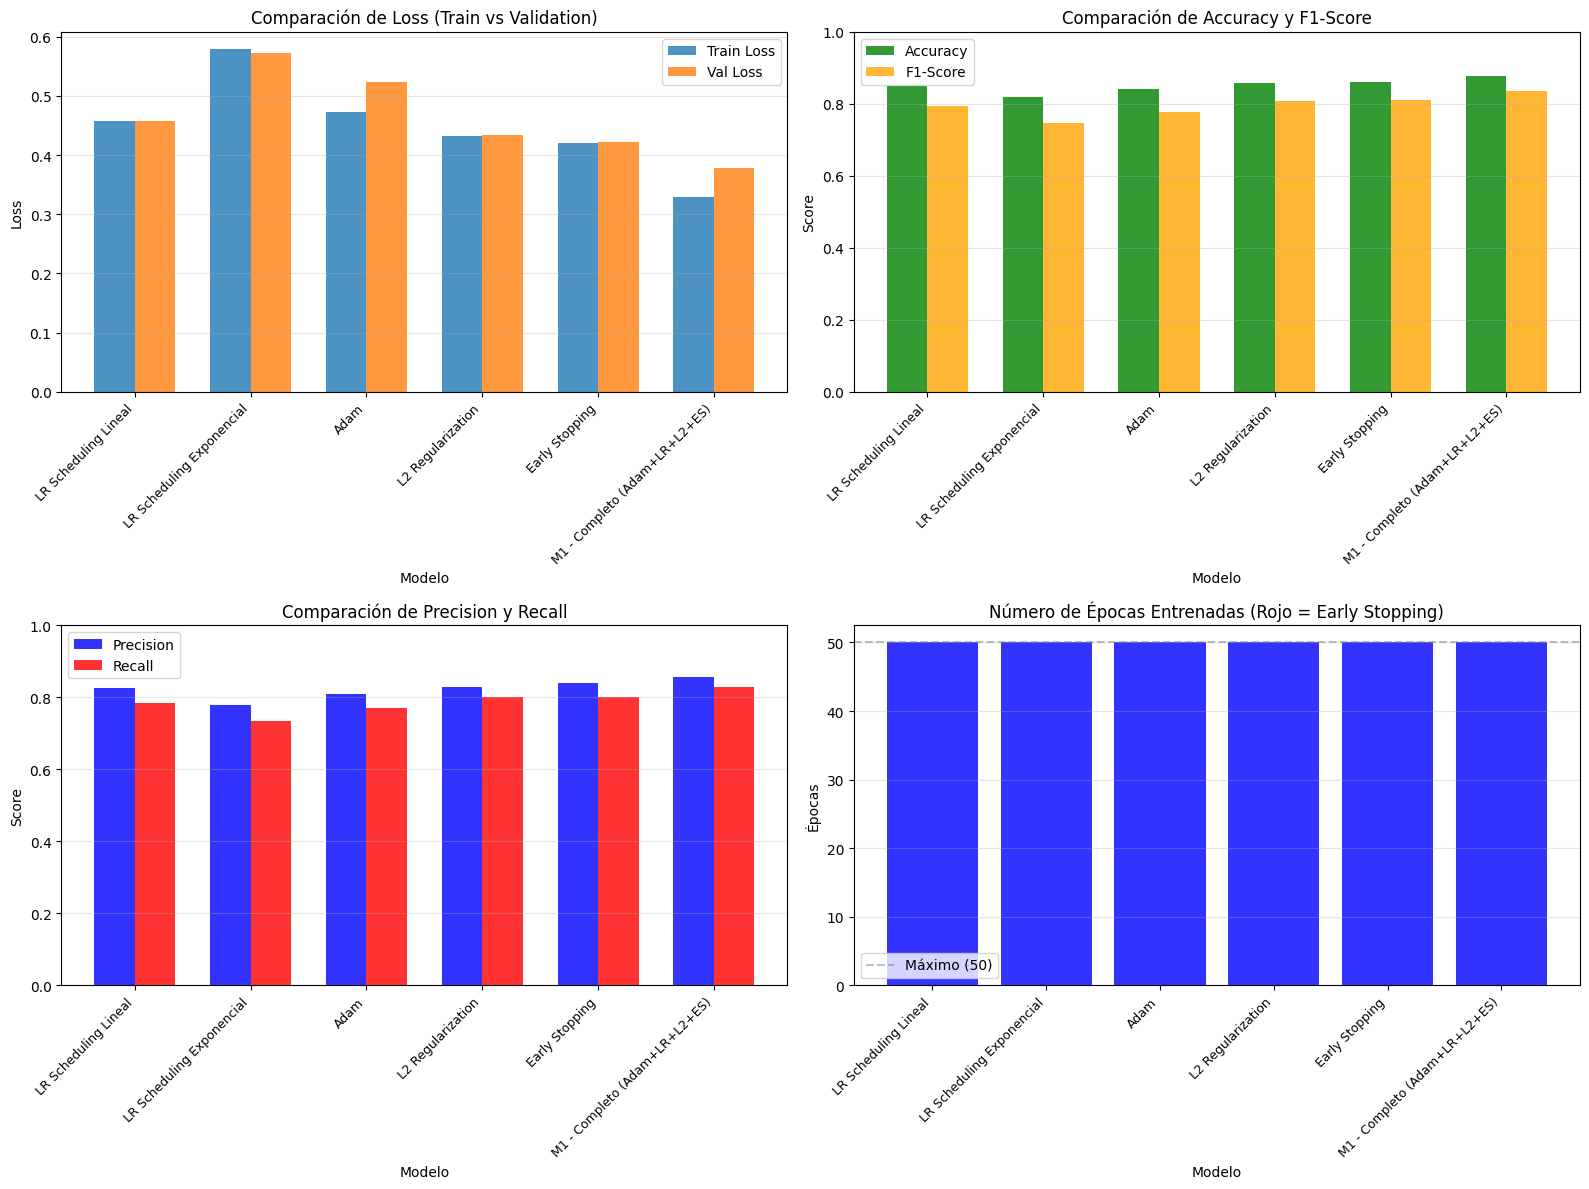


MEJORES MODELOS POR MÉTRICA
Mejor Accuracy: M1 - Completo (Adam+LR+L2+ES) (0.8760)
Mejor F1-Score: M1 - Completo (Adam+LR+L2+ES) (0.8359)
Menor Val Loss: M1 - Completo (Adam+LR+L2+ES) (0.3778)
Mejor Precision: M1 - Completo (Adam+LR+L2+ES) (0.8554)
Mejor Recall: M1 - Completo (Adam+LR+L2+ES) (0.8300)


In [ ]:
# Visualización gráfica de la comparación de modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Convertir columnas numéricas de string a float para graficar
metrics_df_plot = metrics_df.copy()
for col in ['Train Loss', 'Val Loss', 'Accuracy', 'F1-Score', 'Precision', 'Recall']:
    metrics_df_plot[col] = metrics_df_plot[col].astype(float)

# 1. Comparación de Losses
ax = axes[0, 0]
x = np.arange(len(metrics_df_plot))
width = 0.35
ax.bar(x - width/2, metrics_df_plot['Train Loss'], width, label='Train Loss', alpha=0.8)
ax.bar(x + width/2, metrics_df_plot['Val Loss'], width, label='Val Loss', alpha=0.8)
ax.set_xlabel('Modelo')
ax.set_ylabel('Loss')
ax.set_title('Comparación de Loss (Train vs Validation)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df_plot['Modelo'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Comparación de Accuracy y F1-Score
ax = axes[0, 1]
x = np.arange(len(metrics_df_plot))
width = 0.35
ax.bar(x - width/2, metrics_df_plot['Accuracy'], width, label='Accuracy', alpha=0.8, color='green')
ax.bar(x + width/2, metrics_df_plot['F1-Score'], width, label='F1-Score', alpha=0.8, color='orange')
ax.set_xlabel('Modelo')
ax.set_ylabel('Score')
ax.set_title('Comparación de Accuracy y F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df_plot['Modelo'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# 3. Comparación de Precision y Recall
ax = axes[1, 0]
x = np.arange(len(metrics_df_plot))
width = 0.35
ax.bar(x - width/2, metrics_df_plot['Precision'], width, label='Precision', alpha=0.8, color='blue')
ax.bar(x + width/2, metrics_df_plot['Recall'], width, label='Recall', alpha=0.8, color='red')
ax.set_xlabel('Modelo')
ax.set_ylabel('Score')
ax.set_title('Comparación de Precision y Recall')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df_plot['Modelo'], rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])



# 4. Número de épocas entrenadas
ax = axes[1, 1]
colors = ['red' if e < 50 else 'blue' for e in metrics_df_plot['Épocas']]
ax.bar(x, metrics_df_plot['Épocas'], alpha=0.8, color=colors)
ax.set_xlabel('Modelo')
ax.set_ylabel('Épocas')
ax.set_title('Número de Épocas Entrenadas (Rojo = Early Stopping)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df_plot['Modelo'], rotation=45, ha='right', fontsize=9)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Máximo (50)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Identificar el mejor modelo según diferentes métricas
print("\n" + "="*100)
print("MEJORES MODELOS POR MÉTRICA")
print("="*100)
print(f"Mejor Accuracy: {metrics_df_plot.loc[metrics_df_plot['Accuracy'].idxmax(), 'Modelo']} ({metrics_df_plot['Accuracy'].max():.4f})")
print(f"Mejor F1-Score: {metrics_df_plot.loc[metrics_df_plot['F1-Score'].idxmax(), 'Modelo']} ({metrics_df_plot['F1-Score'].max():.4f})")
print(f"Menor Val Loss: {metrics_df_plot.loc[metrics_df_plot['Val Loss'].idxmin(), 'Modelo']} ({metrics_df_plot['Val Loss'].min():.4f})")
print(f"Mejor Precision: {metrics_df_plot.loc[metrics_df_plot['Precision'].idxmax(), 'Modelo']} ({metrics_df_plot['Precision'].max():.4f})")
print(f"Mejor Recall: {metrics_df_plot.loc[metrics_df_plot['Recall'].idxmax(), 'Modelo']} ({metrics_df_plot['Recall'].max():.4f})")
print("="*100)

### B

veo unicamente con el modelo comleto y vario un h a la vez

In [ ]:
import time
import cupy as cp
import numpy as np
import pandas as pd # Para mostrar resultados fácilmente

# --- Configuración Base y Listas de Parámetros a Probar ---
BASE_LR = 0.01           # Learning rate inicial fijo para esta exploración
BATCH_SIZE_EXP = 256     # Tamaño de batch fijo
EPOCHS_EXPLORE = 30      # Épocas para cada prueba (puede ser menor que 50 para acelerar)

# Parámetros a explorar (puedes ajustar estos rangos)
lambdas_to_try = [0.0001, 0.001, 0.01]
decay_rates_to_try = [0.98, 0.95, 0.90]
patiences_to_try = [10, 20, 30]

# Variables para guardar los mejores hiperparámetros encontrados
best_lambda = None
best_decay_rate = None
best_patience = None

# Lista para guardar todos los resultados de la exploración
m1_hyper_results = []

# --- 1. Exploración de Lambda (L2 Regularization) ---
print("\n" + "="*80)
print(" PASO 1: Explorando Lambda (L2 Regularization)")
print(" Fijando: LR_schedule=exp, decay_rate=0.95, patience=20")
print("="*80)

overall_best_val_loss = float('inf')
results_step1 = []

# Parámetros fijos para este paso
fixed_decay_rate = 0.95
fixed_patience = 20

for current_lambda in lambdas_to_try:
    print(f"\n--- Probando Lambda = {current_lambda} ---")
    model_step1 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47],
                      batch_size=BATCH_SIZE_EXP, optimizer='adam')
    
    start_time_step = time.time()
    history_step1 = model_step1.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                      epochs=EPOCHS_EXPLORE, learning_rate=BASE_LR,
                                      lr_schedule='exponential', lr_schedule_params={'decay_rate': fixed_decay_rate},
                                      lambda_reg=current_lambda, # VARIACIÓN
                                      early_stopping_patience=fixed_patience, 
                                      verbose=True) # Menos output durante exploración
    end_time_step = time.time()
    
    min_val_loss = min(history_step1['val_loss']) if history_step1['val_loss'] else float('inf')
    epochs_run = len(history_step1['train_loss'])
    time_taken = end_time_step - start_time_step
    
    results_step1.append({
        'lambda_reg': current_lambda, 
        'min_val_loss': min_val_loss,
        'epochs_run': epochs_run,
        'time_seconds': time_taken
    })
    print(f"  Resultado: Min Val Loss={min_val_loss:.4f} ({epochs_run} épocas, {time_taken:.1f}s)")
    
    if min_val_loss < overall_best_val_loss:
        overall_best_val_loss = min_val_loss
        best_lambda = current_lambda
        print(f"  ✨ Nuevo mejor Lambda encontrado!")

print("\n" + "-"*40)
print("Resultados Exploración Lambda:")
results_df_step1 = pd.DataFrame(results_step1)
print(results_df_step1.to_string(index=False, float_format="%.4f"))
print(f"\n➡️ Mejor Lambda seleccionado: {best_lambda} (Val Loss: {overall_best_val_loss:.4f})")
print("-" * 40)
m1_hyper_results.extend(results_step1) # Guardar resultados globales

# Limpieza de memoria (opcional, descomentar si hay problemas)
del model_step1, history_step1
cp.get_default_memory_pool().free_all_blocks()

# --- 2. Exploración de Decay Rate (LR Schedule) ---
print("\n" + "="*80)
print(" PASO 2: Explorando Decay Rate (LR Schedule)")
print(f" Usando: best_lambda={best_lambda}")
print(" Fijando: patience=20")
print("="*80)

overall_best_val_loss = float('inf') # Reiniciar para este paso
results_step2 = []

for current_decay_rate in decay_rates_to_try:
    print(f"\n--- Probando Decay Rate = {current_decay_rate} ---")
    model_step2 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47],
                      batch_size=BATCH_SIZE_EXP, optimizer='adam')
                      
    start_time_step = time.time()
    history_step2 = model_step2.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                      epochs=EPOCHS_EXPLORE, learning_rate=BASE_LR,
                                      lr_schedule='exponential', lr_schedule_params={'decay_rate': current_decay_rate}, # VARIACIÓN
                                      lambda_reg=best_lambda, # Usar el mejor lambda
                                      early_stopping_patience=fixed_patience, 
                                      verbose=True) 
    end_time_step = time.time()

    min_val_loss = min(history_step2['val_loss']) if history_step2['val_loss'] else float('inf')
    epochs_run = len(history_step2['train_loss'])
    time_taken = end_time_step - start_time_step
    
    results_step2.append({
        'decay_rate': current_decay_rate, 
        'min_val_loss': min_val_loss,
        'epochs_run': epochs_run,
        'time_seconds': time_taken,
        'lambda_used': best_lambda # Documentar qué lambda se usó
    })
    print(f"  Resultado: Min Val Loss={min_val_loss:.4f} ({epochs_run} épocas, {time_taken:.1f}s)")
    
    if min_val_loss < overall_best_val_loss:
        overall_best_val_loss = min_val_loss
        best_decay_rate = current_decay_rate
        print(f"  ✨ Nuevo mejor Decay Rate encontrado!")

print("\n" + "-"*40)
print("Resultados Exploración Decay Rate:")
results_df_step2 = pd.DataFrame(results_step2)
print(results_df_step2.to_string(index=False, float_format="%.4f"))
print(f"\n➡️ Mejor Decay Rate seleccionado: {best_decay_rate} (Val Loss: {overall_best_val_loss:.4f})")
print("-" * 40)
m1_hyper_results.extend(results_step2)

# Limpieza de memoria
del model_step2, history_step2
cp.get_default_memory_pool().free_all_blocks()

# --- 3. Exploración de Patience (Early Stopping) ---
print("\n" + "="*80)
print(" PASO 3: Explorando Patience (Early Stopping)")
print(f" Usando: best_lambda={best_lambda}, best_decay_rate={best_decay_rate}")
print("="*80)

overall_best_val_loss = float('inf') # Reiniciar para este paso
results_step3 = []

for current_patience in patiences_to_try:
    print(f"\n--- Probando Patience = {current_patience} ---")
    model_step3 = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47],
                      batch_size=BATCH_SIZE_EXP, optimizer='adam')
                      
    start_time_step = time.time()
    history_step3 = model_step3.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                      epochs=EPOCHS_EXPLORE, learning_rate=BASE_LR,
                                      lr_schedule='exponential', lr_schedule_params={'decay_rate': best_decay_rate}, # Usar el mejor decay
                                      lambda_reg=best_lambda, # Usar el mejor lambda
                                      early_stopping_patience=current_patience, # VARIACIÓN
                                      verbose=True)
    end_time_step = time.time()

    min_val_loss = min(history_step3['val_loss']) if history_step3['val_loss'] else float('inf')
    epochs_run = len(history_step3['train_loss'])
    time_taken = end_time_step - start_time_step
    
    results_step3.append({
        'patience': current_patience, 
        'min_val_loss': min_val_loss,
        'epochs_run': epochs_run,
        'time_seconds': time_taken,
        'lambda_used': best_lambda,
        'decay_rate_used': best_decay_rate
    })
    print(f"  Resultado: Min Val Loss={min_val_loss:.4f} ({epochs_run} épocas, {time_taken:.1f}s)")
    
    if min_val_loss < overall_best_val_loss:
        overall_best_val_loss = min_val_loss
        best_patience = current_patience
        print(f"  ✨ Nueva mejor Patience encontrada!")

print("\n" + "-"*40)
print("Resultados Exploración Patience:")
results_df_step3 = pd.DataFrame(results_step3)
print(results_df_step3.to_string(index=False, float_format="%.4f"))
print(f"\n➡️ Mejor Patience seleccionada: {best_patience} (Val Loss: {overall_best_val_loss:.4f})")
print("-" * 40)
m1_hyper_results.extend(results_step3)

# Limpieza de memoria
del model_step3, history_step3
cp.get_default_memory_pool().free_all_blocks()



In [ ]:
# --- 4. Entrenamiento Final de M1 con los Mejores Hiperparámetros ---
print("\n" + "="*80)
print(" PASO 4: Entrenando M1 Final con los Mejores Hiperparámetros")
print(f" Lambda={best_lambda}, Decay Rate={best_decay_rate}, Patience={best_patience}")
print(" Entrenando por más épocas (ej: 50) con Early Stopping")
print("="*80)

FINAL_EPOCHS = 50 # Definir épocas máximas para el entrenamiento final

model_m1_final = MLP(n_layers=3, layer_sizes=[784, 128, 64, 47], 
                     batch_size=BATCH_SIZE_EXP, optimizer='adam')
                     
start_time_final = time.time()
history_m1_final = model_m1_final.train(X_train_T, y_train_onehot, X_val_T, y_val_onehot,
                                        epochs=FINAL_EPOCHS, 
                                        learning_rate=BASE_LR,
                                        lr_schedule='exponential', lr_schedule_params={'decay_rate': best_decay_rate},
                                        lambda_reg=best_lambda,
                                        early_stopping_patience=best_patience, 
                                        verbose=True) # Mostrar output del entrenamiento final
end_time_final = time.time()

final_min_val_loss = min(history_m1_final['val_loss']) if history_m1_final['val_loss'] else float('inf')
final_epochs_run = len(history_m1_final['train_loss'])
final_time_taken = end_time_final - start_time_final

print(f"\n--- Entrenamiento Final M1 Completado ---")
print(f"  Mejor Val Loss: {final_min_val_loss:.4f}")
print(f"  Épocas corridas: {final_epochs_run} / {FINAL_EPOCHS}")
print(f"  Tiempo total: {final_time_taken:.1f}s ({final_time_taken/60:.2f} min)")

# Guardar el modelo y su historial final para usar en las siguientes secciones
# (Puedes renombrar las variables si prefieres mantener las originales `model_m1` y `history_m1`)
model_m1 = model_m1_final 
history_m1 = history_m1_final 

# --- Resumen Global de la Exploración ---
print("\n" + "="*80)
print(" Resumen Global de la Exploración de Hiperparámetros para M1")
print("="*80)
all_results_df = pd.DataFrame(m1_hyper_results)
# Llenar NaNs para mejor visualización
all_results_df.fillna('-', inplace=True) 
print(all_results_df.to_string(index=False, float_format="%.4f"))
print("\nMejores Hiperparámetros Seleccionados:")
print(f" - Lambda (L2): {best_lambda}")
print(f" - Decay Rate (LR Exp): {best_decay_rate}")
print(f" - Patience (ES): {best_patience}")
print("="*80)

FALTA VARIAR LAS ARQUITECTURAS

## 3.b) Exploración de Arquitecturas para M1

Probar diferentes arquitecturas para encontrar la configuración óptima

In [ ]:
print("="*80)
print("EXPLORACIÓN DE ARQUITECTURAS - Sección 3.b")
print("="*80)
print("Buscando mejor arquitectura con hiperparámetros optimizados de M1\n")
print(f"Usando hiperparámetros encontrados en experimentos previos:")
print(f"  - Lambda (L2): {best_lambda}")
print(f"  - Decay Rate: {best_decay_rate}")
print(f"  - Patience: {best_patience}")
print(f"  - Learning Rate: 0.001 (Adam optimizado)")
print(f"  - Batch Size: 128\n")

architectures_to_test = [
    ([256, 128], "Arch_1: [256, 128]"),
    ([512, 256, 128], "Arch_2: [512, 256, 128]"),
    ([128, 128], "Arch_3: [128, 128]"),
    ([64, 64, 64], "Arch_4: [64, 64, 64]"),
    ([256, 128, 64], "Arch_5: [256, 128, 64]")
]

arch_results = []
ARCH_LR = 0.001
ARCH_DECAY = best_decay_rate
ARCH_LAMBDA = best_lambda
ARCH_PATIENCE = best_patience
ARCH_BATCH = 128

for arch, arch_name in architectures_to_test:
    print(f"\n{'='*80}")
    print(f"Entrenando: {arch_name}")
    print(f"{'='*80}")
    
    layer_sizes_arch = [784] + arch + [47]
    model_arch = MLP(n_layers=len(arch)+1, layer_sizes=layer_sizes_arch, 
                     batch_size=ARCH_BATCH, optimizer='adam')
    
    history_arch = model_arch.train(
        X_train_T, y_train_onehot, X_val_T, y_val_onehot,
        epochs=50, learning_rate=ARCH_LR,
        lr_schedule='exponential',
        lr_schedule_params={'decay_rate': ARCH_DECAY},
        lambda_reg=ARCH_LAMBDA,
        early_stopping_patience=ARCH_PATIENCE,
        verbose=True
    )
    
    y_pred_arch = model_arch.predict(cp.asarray(X_val_T))
    y_pred_arch_cpu = cp.asnumpy(y_pred_arch)
    acc_arch = accuracy(y_val, y_pred_arch_cpu)
    
    arch_results.append({
        'Arquitectura': arch_name,
        'Capas': str(arch),
        'Val Loss': f"{history_arch['val_loss'][-1]:.4f}",
        'Accuracy': f"{acc_arch:.4f}",
        'Épocas': len(history_arch['train_loss'])
    })

arch_df = pd.DataFrame(arch_results)
print("\n" + "="*80)
print("COMPARACIÓN DE ARQUITECTURAS")
print("="*80)
print(arch_df.to_string(index=False))
print("="*80)

best_arch_idx = arch_df['Accuracy'].astype(float).idxmax()
print(f"\n✓ Mejor arquitectura: {arch_df.loc[best_arch_idx, 'Arquitectura']}")
print(f"  Accuracy: {arch_df.loc[best_arch_idx, 'Accuracy']}")
print(f"  Val Loss: {arch_df.loc[best_arch_idx, 'Val Loss']}")

# 4. Desarrollo de una Red Neuronal con PyTorch


In [ ]:
# ============================================================================
# MODELO M2 - PyTorch Implementation
# ============================================================================
# Toda la implementación de PyTorch ahora está en models.py
# Aquí solo usamos las clases para entrenar y evaluar

import torch

# Verificar dispositivo disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

In [ ]:
print("\n" + "="*80)
print("CONFIGURACIÓN DEL MODELO M2 (PyTorch)")
print("="*80)

# Crear modelo con la misma arquitectura que M1
input_size_pt = 784
hidden_sizes_pt = [128, 64]
num_classes_pt = 47

print(f"\nArquitectura:")
print(f"  Input: {input_size_pt}")
print(f"  Hidden: {hidden_sizes_pt}")
print(f"  Output: {num_classes_pt}")

# Instanciar modelo y trainer
model_m2 = MLP_PyTorch(input_size=input_size_pt, 
                       hidden_sizes=hidden_sizes_pt, 
                       num_classes=num_classes_pt)

trainer_m2 = PyTorchTrainer(model_m2, device='cuda')

print(f"\nModelo creado y movido a: {trainer_m2.device}")
print(f"Número de parámetros: {sum(p.numel() for p in model_m2.parameters()):,}")

# Preparar DataLoaders
batch_size_pytorch = 128
print(f"\nPreparando datos con batch_size={batch_size_pytorch}...")

train_loader, val_loader = trainer_m2.prepare_data(
    X_train_flat, y_train,
    X_val_flat, y_val,
    batch_size=batch_size_pytorch
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print("\n✓ Datos preparados correctamente")

In [ ]:
print("\n" + "="*80)
print("ENTRENAMIENTO DEL MODELO M2 (PyTorch)")
print("="*80)
print("Configuración: Adam + LR Exponential + L2 + Early Stopping")
print("(Mismos hiperparámetros que M1 para comparación justa)")
print("="*80 + "\n")

# Entrenar con los mismos hiperparámetros que M1
history_m2 = trainer_m2.train(
    train_loader, 
    val_loader,
    epochs=50,
    learning_rate=0.001,          # Mismo que M1
    weight_decay=0.001,            # Lambda reg = 0.001 (mismo que M1)
    lr_schedule='exponential',
    lr_schedule_params={'decay_rate': 0.95},  # Mismo que M1
    early_stopping_patience=20,    # Mismo que M1
    verbose=True
)

In [ ]:
# Visualizar curvas de entrenamiento de M2
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_m2['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0].plot(history_m2['val_loss'], label='Validation Loss', marker='s', markersize=3)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Cross-Entropy Loss')
axes[0].set_title('M2 (PyTorch) - Evolución del Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_m2['train_acc'], label='Train Accuracy', marker='o', markersize=3)
axes[1].plot(history_m2['val_acc'], label='Validation Accuracy', marker='s', markersize=3)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('M2 (PyTorch) - Evolución del Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de convergencia
print("\n" + "="*80)
print("ANÁLISIS DE CONVERGENCIA - M2")
print("="*80)
best_epoch = np.argmin(history_m2['val_loss'])
print(f"Mejor Val Loss: {history_m2['val_loss'][best_epoch]:.4f} en época {best_epoch+1}")
print(f"Loss final - Train: {history_m2['train_loss'][-1]:.4f}, Val: {history_m2['val_loss'][-1]:.4f}")
print(f"Accuracy final - Train: {history_m2['train_acc'][-1]:.4f}, Val: {history_m2['val_acc'][-1]:.4f}")
print(f"Gap Train-Val Loss: {abs(history_m2['train_loss'][-1] - history_m2['val_loss'][-1]):.4f}")
print("="*80)

In [ ]:
print("\n" + "="*80)
print("EVALUACIÓN DEL MODELO M2 EN CONJUNTO DE VALIDACIÓN")
print("="*80 + "\n")

# Hacer predicciones en validación
y_pred_m2_val = trainer_m2.predict(X_val_flat)

# Calcular métricas usando nuestras funciones de metrics.py
print("=== Métricas en Validación (VAL) para M2 ===")
metrics_M2_val = evaluate_model(y_val, y_pred_m2_val, n_classes=num_classes_pt, verbose=True)

# Agregar loss para comparación
metrics_M2_val['val_loss'] = history_m2['val_loss'][-1]

# Matriz de confusión
plot_confusion_matrix(
    metrics_M2_val['confusion_matrix'], 
    title='Matriz de Confusión M2 (PyTorch) - Validación'
)
plt.show()

In [ ]:
print("\n" + "="*100)
print("COMPARACIÓN FINAL: M1 (Custom CuPy) vs M2 (PyTorch)")
print("="*100)

# Obtener métricas de M1 (desde la tabla anterior)
metrics_M1_row = metrics_df[metrics_df['Modelo'] == 'M1 - Completo (Adam+LR+L2+ES)'].iloc[0]

# Crear tabla comparativa
comparison_data = {
    'Métrica': [
        'Validation Loss',
        'Accuracy', 
        'F1-Score Macro',
        'Precision Promedio',
        'Recall Promedio',
        'Tiempo Total (min)',
        'Tiempo por Época (s)'
    ],
    'M1 (Custom CuPy)': [
        float(metrics_M1_row['Val Loss']),
        float(metrics_M1_row['Accuracy']),
        float(metrics_M1_row['F1-Score']),
        float(metrics_M1_row['Precision']),
        float(metrics_M1_row['Recall']),
        history_m1_final['training_time']['total_minutes'],
        history_m1_final['training_time']['seconds_per_epoch']
    ],
    'M2 (PyTorch)': [
        metrics_M2_val['val_loss'],
        metrics_M2_val['accuracy'],
        metrics_M2_val['f1_macro'],
        np.mean(metrics_M2_val['precision_per_class']),
        np.mean(metrics_M2_val['recall_per_class']),
        history_m2['training_time']['total_minutes'],
        history_m2['training_time']['seconds_per_epoch']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))
print("="*100)

# Análisis de diferencias
print("\n=== Análisis de Diferencias ===")
diff_acc = abs(comparison_df.loc[1, 'M1 (Custom CuPy)'] - comparison_df.loc[1, 'M2 (PyTorch)'])
diff_loss = abs(comparison_df.loc[0, 'M1 (Custom CuPy)'] - comparison_df.loc[0, 'M2 (PyTorch)'])
diff_f1 = abs(comparison_df.loc[2, 'M1 (Custom CuPy)'] - comparison_df.loc[2, 'M2 (PyTorch)'])
diff_time = abs(comparison_df.loc[5, 'M1 (Custom CuPy)'] - comparison_df.loc[5, 'M2 (PyTorch)'])

print(f"Diferencia en Accuracy: {diff_acc:.4f} ({diff_acc*100:.2f}%)")
print(f"Diferencia en Val Loss: {diff_loss:.4f}")
print(f"Diferencia en F1-Score: {diff_f1:.4f}")
print(f"Diferencia en Tiempo: {diff_time:.2f} min")

# Validación
if diff_acc < 0.02 and diff_loss < 0.1:
    print("\n✓ Validación exitosa: M1 y M2 tienen rendimiento similar.")
    print("  La implementación custom con CuPy es equivalente a PyTorch.")
else:
    print("\n⚠️ Advertencia: M1 y M2 difieren significativamente.")
    print("  Revisar hiperparámetros o implementaciones.")

# Identificar el mejor modelo
if comparison_df.loc[1, 'M2 (PyTorch)'] > comparison_df.loc[1, 'M1 (Custom CuPy)']:
    best_model = "M2 (PyTorch)"
    best_acc = comparison_df.loc[1, 'M2 (PyTorch)']
else:
    best_model = "M1 (Custom CuPy)"
    best_acc = comparison_df.loc[1, 'M1 (Custom CuPy)']

print(f"\n🏆 Mejor modelo: {best_model} con Accuracy = {best_acc:.4f}")
print("="*100)


## 4.b) Exploración con Arquitecturas Avanzadas (M3)

Explorar arquitecturas, activaciones modernas y dropout con PyTorch

In [ ]:
print("="*80)
print("M3 - EXPERIMENTACIÓN CON ARQUITECTURAS PYTORCH")
print("="*80)

m3_architectures = [
    ([256, 128], "M3_Arch_1: [256, 128]"),
    ([512, 256], "M3_Arch_2: [512, 256]"),
    ([128, 128, 64], "M3_Arch_3: [128, 128, 64]"),
    ([256, 256, 128], "M3_Arch_4: [256, 256, 128]")
]

m3_arch_results = []

for hidden_arch, arch_name in m3_architectures:
    print(f"\n{'='*80}")
    print(f"Entrenando: {arch_name}")
    print(f"{'='*80}")
    
    model_m3_arch = MLP_PyTorch_Advanced(
        input_size=784, 
        hidden_sizes=hidden_arch,
        num_classes=47,
        activation='relu',
        dropout_rate=0.0
    )
    
    trainer_m3_arch = PyTorchTrainer(model_m3_arch, device='cuda')
    train_loader_m3, val_loader_m3 = trainer_m3_arch.prepare_data(
        X_train_flat, y_train, X_val_flat, y_val, batch_size=128
    )
    
    history_m3_arch = trainer_m3_arch.train(
        train_loader_m3, val_loader_m3,
        epochs=50, learning_rate=0.001, weight_decay=0.001,
        lr_schedule='exponential',
        lr_schedule_params={'decay_rate': 0.95},
        early_stopping_patience=20,
        verbose=True
    )
    
    y_pred_m3_arch = trainer_m3_arch.predict(X_val_flat)
    acc_m3_arch = accuracy(y_val, y_pred_m3_arch)
    
    m3_arch_results.append({
        'Arquitectura': arch_name,
        'Capas': str(hidden_arch),
        'Val Loss': f"{history_m3_arch['val_loss'][-1]:.4f}",
        'Accuracy': f"{acc_m3_arch:.4f}",
        'Épocas': len(history_m3_arch['train_loss'])
    })

m3_arch_df = pd.DataFrame(m3_arch_results)
print("\n" + "="*80)
print("COMPARACIÓN ARQUITECTURAS M3")
print("="*80)
print(m3_arch_df.to_string(index=False))
print("="*80)

In [ ]:
best_arch_idx = m3_arch_df['Accuracy'].astype(float).idxmax()
BEST_M3_ARCH = m3_architectures[best_arch_idx][0]

print(f"\n{'='*80}")
print("MEJOR ARQUITECTURA SELECCIONADA PARA M3")
print(f"{'='*80}")
print(f"Arquitectura: {BEST_M3_ARCH}")
print(f"Accuracy: {m3_arch_df.loc[best_arch_idx, 'Accuracy']}")
print(f"Val Loss: {m3_arch_df.loc[best_arch_idx, 'Val Loss']}")
print(f"{'='*80}")

In [ ]:
print("\n" + "="*80)
print("M3 - EXPERIMENTACIÓN CON FUNCIONES DE ACTIVACIÓN")
print("="*80)

activations_to_test = ['relu', 'leakyrelu', 'gelu', 'silu']
m3_activation_results = []

for activation_name in activations_to_test:
    print(f"\n{'='*80}")
    print(f"Entrenando con activación: {activation_name.upper()}")
    print(f"{'='*80}")
    
    model_m3_act = MLP_PyTorch_Advanced(
        input_size=784,
        hidden_sizes=BEST_M3_ARCH,
        num_classes=47,
        activation=activation_name,
        dropout_rate=0.0
    )
    
    trainer_m3_act = PyTorchTrainer(model_m3_act, device='cuda')
    train_loader_act, val_loader_act = trainer_m3_act.prepare_data(
        X_train_flat, y_train, X_val_flat, y_val, batch_size=128
    )
    
    history_m3_act = trainer_m3_act.train(
        train_loader_act, val_loader_act,
        epochs=50, learning_rate=0.001, weight_decay=0.001,
        lr_schedule='exponential',
        lr_schedule_params={'decay_rate': 0.95},
        early_stopping_patience=20,
        verbose=True
    )
    
    y_pred_m3_act = trainer_m3_act.predict(X_val_flat)
    acc_m3_act = accuracy(y_val, y_pred_m3_act)
    
    m3_activation_results.append({
        'Activación': activation_name.upper(),
        'Val Loss': f"{history_m3_act['val_loss'][-1]:.4f}",
        'Accuracy': f"{acc_m3_act:.4f}",
        'Épocas': len(history_m3_act['train_loss'])
    })

m3_act_df = pd.DataFrame(m3_activation_results)
print("\n" + "="*80)
print("COMPARACIÓN FUNCIONES DE ACTIVACIÓN M3")
print("="*80)
print(m3_act_df.to_string(index=False))
print("="*80)

In [ ]:
best_act_idx = m3_act_df['Accuracy'].astype(float).idxmax()
BEST_M3_ACTIVATION = activations_to_test[best_act_idx]

print(f"\n{'='*80}")
print("MEJOR ACTIVACIÓN SELECCIONADA PARA M3")
print(f"{'='*80}")
print(f"Activación: {BEST_M3_ACTIVATION.upper()}")
print(f"Accuracy: {m3_act_df.loc[best_act_idx, 'Accuracy']}")
print(f"Val Loss: {m3_act_df.loc[best_act_idx, 'Val Loss']}")
print(f"{'='*80}")

In [ ]:
print("\n" + "="*80)
print("M3 - EXPERIMENTACIÓN CON DROPOUT")
print("="*80)

dropout_rates = [0.0, 0.1, 0.2, 0.3]
m3_dropout_results = []

for dropout_rate in dropout_rates:
    print(f"\n{'='*80}")
    print(f"Entrenando con Dropout: {dropout_rate}")
    print(f"{'='*80}")
    
    model_m3_drop = MLP_PyTorch_Advanced(
        input_size=784,
        hidden_sizes=BEST_M3_ARCH,
        num_classes=47,
        activation=BEST_M3_ACTIVATION,
        dropout_rate=dropout_rate
    )
    
    trainer_m3_drop = PyTorchTrainer(model_m3_drop, device='cuda')
    train_loader_drop, val_loader_drop = trainer_m3_drop.prepare_data(
        X_train_flat, y_train, X_val_flat, y_val, batch_size=128
    )
    
    history_m3_drop = trainer_m3_drop.train(
        train_loader_drop, val_loader_drop,
        epochs=50, learning_rate=0.001, weight_decay=0.001,
        lr_schedule='exponential',
        lr_schedule_params={'decay_rate': 0.95},
        early_stopping_patience=20,
        verbose=True
    )
    
    y_pred_m3_drop = trainer_m3_drop.predict(X_val_flat)
    acc_m3_drop = accuracy(y_val, y_pred_m3_drop)
    
    m3_dropout_results.append({
        'Dropout': f"{dropout_rate:.1f}",
        'Val Loss': f"{history_m3_drop['val_loss'][-1]:.4f}",
        'Accuracy': f"{acc_m3_drop:.4f}",
        'Épocas': len(history_m3_drop['train_loss'])
    })

m3_drop_df = pd.DataFrame(m3_dropout_results)
print("\n" + "="*80)
print("COMPARACIÓN DROPOUT M3")
print("="*80)
print(m3_drop_df.to_string(index=False))
print("="*80)

In [ ]:
best_drop_idx = m3_drop_df['Accuracy'].astype(float).idxmax()
BEST_M3_DROPOUT = dropout_rates[best_drop_idx]

print(f"\n{'='*80}")
print("MEJOR DROPOUT SELECCIONADO PARA M3")
print(f"{'='*80}")
print(f"Dropout: {BEST_M3_DROPOUT}")
print(f"Accuracy: {m3_drop_df.loc[best_drop_idx, 'Accuracy']}")
print(f"Val Loss: {m3_drop_df.loc[best_drop_idx, 'Val Loss']}")
print(f"{'='*80}")

In [ ]:
print("\n" + "="*80)
print("ENTRENAMIENTO DEL MODELO M3 FINAL")
print("="*80)
print("Mejor configuración encontrada en experimentos anteriores\n")

model_m3_final = MLP_PyTorch_Advanced(
    input_size=784,
    hidden_sizes=BEST_M3_ARCH,
    num_classes=47,
    activation=BEST_M3_ACTIVATION,
    dropout_rate=BEST_M3_DROPOUT
)

trainer_m3_final = PyTorchTrainer(model_m3_final, device='cuda')
train_loader_m3_final, val_loader_m3_final = trainer_m3_final.prepare_data(
    X_train_flat, y_train, X_val_flat, y_val, batch_size=128
)

print(f"Arquitectura: {BEST_M3_ARCH}")
print(f"Activación: {BEST_M3_ACTIVATION.upper()}")
print(f"Dropout: {BEST_M3_DROPOUT}")
print(f"Parámetros: {sum(p.numel() for p in model_m3_final.parameters()):,}\n")

history_m3_final = trainer_m3_final.train(
    train_loader_m3_final, val_loader_m3_final,
    epochs=50, learning_rate=0.001, weight_decay=0.001,
    lr_schedule='exponential',
    lr_schedule_params={'decay_rate': 0.95},
    early_stopping_patience=20,
    verbose=True
)

y_pred_m3_final = trainer_m3_final.predict(X_val_flat)
metrics_M3_val = evaluate_model(y_val, y_pred_m3_final, n_classes=47, verbose=True)
metrics_M3_val['val_loss'] = history_m3_final['val_loss'][-1]

plot_confusion_matrix(metrics_M3_val['confusion_matrix'], 
                     title='Matriz de Confusión M3 (PyTorch Advanced) - Validación')
plt.show()

## 4.c) Comparación Final de los 4 Modelos en Test Set

In [ ]:
print("="*100)
print("EVALUACIÓN DE LOS 4 MODELOS EN TEST SET")
print("="*100)

print("\n1. Evaluando M0 (Baseline Custom)...")
y_pred_M0_test = mlp.predict(cp.asarray(X_test_T))
y_pred_M0_test_cpu = cp.asnumpy(y_pred_M0_test)
metrics_M0_test = evaluate_model(y_test, y_pred_M0_test_cpu, n_classes=47, verbose=False)

print("\n2. Evaluando M1 (Mejor Custom con todas las optimizaciones)...")
y_pred_M1_test = model_m1_final.predict(cp.asarray(X_test_T))
y_pred_M1_test_cpu = cp.asnumpy(y_pred_M1_test)
metrics_M1_test = evaluate_model(y_test, y_pred_M1_test_cpu, n_classes=47, verbose=False)

print("\n3. Evaluando M2 (PyTorch equivalente a M1)...")
y_pred_M2_test = trainer_m2.predict(X_test_flat)
metrics_M2_test = evaluate_model(y_test, y_pred_M2_test, n_classes=47, verbose=False)

print("\n4. Evaluando M3 (PyTorch avanzado con GELU y Dropout)...")
y_pred_M3_test = trainer_m3_final.predict(X_test_flat)
metrics_M3_test = evaluate_model(y_test, y_pred_M3_test, n_classes=47, verbose=False)

test_comparison = pd.DataFrame({
    'Modelo': ['M0 (Baseline)', 'M1 (Best Custom)', 'M2 (PyTorch)', 'M3 (Advanced)'],
    'Accuracy': [
        f"{metrics_M0_test['accuracy']:.4f}",
        f"{metrics_M1_test['accuracy']:.4f}",
        f"{metrics_M2_test['accuracy']:.4f}",
        f"{metrics_M3_test['accuracy']:.4f}"
    ],
    'F1-Score': [
        f"{metrics_M0_test['f1_macro']:.4f}",
        f"{metrics_M1_test['f1_macro']:.4f}",
        f"{metrics_M2_test['f1_macro']:.4f}",
        f"{metrics_M3_test['f1_macro']:.4f}"
    ],
    'Precision': [
        f"{np.mean(metrics_M0_test['precision_per_class']):.4f}",
        f"{np.mean(metrics_M1_test['precision_per_class']):.4f}",
        f"{np.mean(metrics_M2_test['precision_per_class']):.4f}",
        f"{np.mean(metrics_M3_test['precision_per_class']):.4f}"
    ],
    'Recall': [
        f"{np.mean(metrics_M0_test['recall_per_class']):.4f}",
        f"{np.mean(metrics_M1_test['recall_per_class']):.4f}",
        f"{np.mean(metrics_M2_test['recall_per_class']):.4f}",
        f"{np.mean(metrics_M3_test['recall_per_class']):.4f}"
    ]
})

print("\n" + "="*100)
print("RESULTADOS EN TEST SET")
print("="*100)
print(test_comparison.to_string(index=False))
print("="*100)

best_model_idx = test_comparison['Accuracy'].astype(float).idxmax()
print(f"\n🏆 Mejor modelo en TEST: {test_comparison.loc[best_model_idx, 'Modelo']}")
print(f"   Accuracy: {test_comparison.loc[best_model_idx, 'Accuracy']}")
print(f"   F1-Score: {test_comparison.loc[best_model_idx, 'F1-Score']}")

## 4.d) Test de Robustez con Ruido

Evaluar cómo se comportan los modelos frente a datos perturbados

In [ ]:
def add_gaussian_noise(X, noise_level):
    noise = np.random.normal(0, noise_level, X.shape)
    X_noisy = X + noise
    return np.clip(X_noisy, 0, 1)

noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3]
robustness_results = []

print("="*100)
print("TEST DE ROBUSTEZ - Perturbación con Ruido Gaussiano")
print("="*100)

for noise_level in noise_levels:
    print(f"\nNivel de ruido: {noise_level:.2f}")
    
    X_test_noisy_flat = add_gaussian_noise(X_test_flat.copy(), noise_level)
    X_test_noisy_T = X_test_noisy_flat.T.astype(np.float32)
    
    y_pred_M0_noisy = cp.asnumpy(mlp.predict(cp.asarray(X_test_noisy_T)))
    acc_M0_noisy = accuracy(y_test, y_pred_M0_noisy)
    
    y_pred_M1_noisy = cp.asnumpy(model_m1_final.predict(cp.asarray(X_test_noisy_T)))
    acc_M1_noisy = accuracy(y_test, y_pred_M1_noisy)
    
    y_pred_M2_noisy = trainer_m2.predict(X_test_noisy_flat)
    acc_M2_noisy = accuracy(y_test, y_pred_M2_noisy)
    
    y_pred_M3_noisy = trainer_m3_final.predict(X_test_noisy_flat)
    acc_M3_noisy = accuracy(y_test, y_pred_M3_noisy)
    
    robustness_results.append({
        'Noise Level': f"{noise_level:.2f}",
        'M0': f"{acc_M0_noisy:.4f}",
        'M1': f"{acc_M1_noisy:.4f}",
        'M2': f"{acc_M2_noisy:.4f}",
        'M3': f"{acc_M3_noisy:.4f}"
    })

robustness_df = pd.DataFrame(robustness_results)
print("\n" + "="*100)
print("RESULTADOS DE ROBUSTEZ")
print("="*100)
print(robustness_df.to_string(index=False))
print("="*100)

In [ ]:
plt.figure(figsize=(12, 6))

noise_levels_plot = [float(x) for x in robustness_df['Noise Level']]
m0_acc = [float(x) for x in robustness_df['M0']]
m1_acc = [float(x) for x in robustness_df['M1']]
m2_acc = [float(x) for x in robustness_df['M2']]
m3_acc = [float(x) for x in robustness_df['M3']]

plt.plot(noise_levels_plot, m0_acc, marker='o', label='M0 (Baseline)', linewidth=2)
plt.plot(noise_levels_plot, m1_acc, marker='s', label='M1 (Best Custom)', linewidth=2)
plt.plot(noise_levels_plot, m2_acc, marker='^', label='M2 (PyTorch)', linewidth=2)
plt.plot(noise_levels_plot, m3_acc, marker='d', label='M3 (Advanced)', linewidth=2)

plt.xlabel('Nivel de Ruido', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Robustez de los Modelos frente a Ruido Gaussiano', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== Análisis de Degradación ===")
for col in ['M0', 'M1', 'M2', 'M3']:
    clean_acc = float(robustness_df.loc[0, col])
    noisy_acc = float(robustness_df.loc[len(robustness_df)-1, col])
    degradation = (clean_acc - noisy_acc) / clean_acc * 100
    print(f"{col}: {degradation:.2f}% degradación")

# 5. Generación de Predicciones para Entrega

In [ ]:
print("="*80)
print("GENERACIÓN DEL ARCHIVO predictions.csv")
print("="*80)

best_model_idx = test_comparison['Accuracy'].astype(float).idxmax()
best_model_name = test_comparison.loc[best_model_idx, 'Modelo']

print(f"\nUsando {best_model_name} para generar predicciones...")

if best_model_idx == 3:
    predictions = y_pred_M3_test
elif best_model_idx == 2:
    predictions = y_pred_M2_test
elif best_model_idx == 1:
    predictions = y_pred_M1_test_cpu
else:
    predictions = y_pred_M0_test_cpu

predictions_df = pd.DataFrame({
    'id': range(len(predictions)),
    'prediction': predictions
})

predictions_df.to_csv('predicciones.csv', index=False)

print(f"\n✓ Archivo 'predicciones.csv' generado exitosamente")
print(f"  Total de predicciones: {len(predictions)}")
print(f"  Primeras 5 predicciones: {predictions[:5]}")
print(f"  Distribución de predicciones:")
unique_preds, counts_preds = np.unique(predictions, return_counts=True)
for pred, count in zip(unique_preds[:10], counts_preds[:10]):
    print(f"    Clase {pred}: {count} predicciones")